<a href="https://colab.research.google.com/github/MedicalImageAnalysisTutorials/DeepLearning4All/blob/main/IA_DNN_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, I will try to provide a practical tutorial for deep learning using simple examples. I will try to use simple implementation and avoid using built-in functions to give clear idea about the concept. You need basic programming knowledge. 

**The Classification Problem:**

We have data represented usually by an array (could be 1D, 2D, or ND). Note the images usually are 3D arrays e.g. with size hight,width,channels.

We also have "labels" or "classes" so for each sample in our data we have its class or label. 

An example:

                 index     sample (X)     label (Y)  
                  1         image1          car                      
                  2         image2          car                      
                  3         image3          dog                               
                  4         image4          bike                      
                  5         image5          bike                             
                  6         image6          dog                      
                  .
                  .
                  . 


Another example:

                 index         sample (X)         label (Y)  
                  1         [20 24 25 ... 23]        1                      
                  2         [10 20 8  ... 50]        2
                  3         [40 24 12 ... 11]        1                      
                  4         [12 15 30 ... 60]        1
                  5         [19 70 25 ... 22]        1                      
                  6         [0  90 23 ... 10]        2
                  .
                  .
                  . 


We want to find a way to predict the class or the label for new samples that we do not know. 

There are many machine learning algorithms available e.g. [K-nearest_neighbors  (KNN)](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) algorithm or [support vector machine (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine)

Here we will investigate the [neural network (NN)](http://neuralnetworksanddeeplearning.com/chap1.html) and the [convolution neural networks (CNN)](https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/) approaches. 



In [50]:
# Setup 
import os, random, time
import numpy as np
import matplotlib.pyplot as plt
import cv2 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models

# Image classification using NN

I will use two popular public datasets [MINST](http://yann.lecun.com/exdb/mnist/) and [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Both have 10 classes. 

## Reading and exploring the datasets



dataset shape   :  (50000, 28, 28, 1)
number of images:  50000
image size      :  (28, 28, 1)
image data type :  <class 'numpy.uint8'>
image max  value:  255
image min  value:  0
gray or binary image (not color image)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


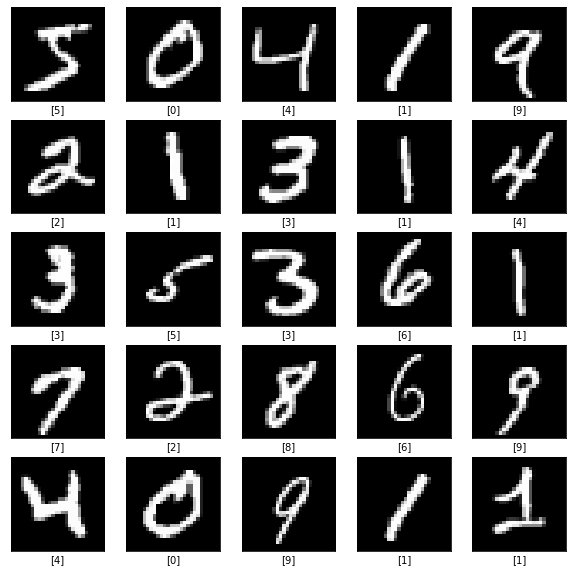

In [59]:
datasetID = 1  # minst is selected by default, for cifar10 use 2
NNID      = 2  # NN is by default, for DNN use 2 
number_of_classes = 10  # each datasets have 10 classes


# minst dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
class_names = range(10)
if datasetID==2:
    # cifar10 dataset
    # The CIFAR10 dataset contains 60,000 color images in 10 classes, 
    # with 6,000 images in each class.
    # The dataset is divided into 50,000 training images and 10,000 testing images.
    # The classes are mutually exclusive and there is no overlap between them.

    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# get size 
h = x_train.shape[1] # image height
w = x_train.shape[2] # image width
# check for rgb 
try:
    # number of channels
    c =  x_train.shape[3]
except:
    # number of channels
    c =  1
    # if there is no number of channels, add 1
    x_train  =  x_train[..., np.newaxis] # np.reshape(x_train, (-1, h,w,1))
    y_train  =  y_train[..., np.newaxis] # np.reshape(y_train, (-1, h,w,1))
    x_test   =  x_test[..., np.newaxis]  # np.reshape(x_test,  (-1, h,w,1))
    y_test   =  y_test[..., np.newaxis]  # np.reshape(y_test,  (-1, h,w,1))


# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

number_of_pixels = h * w * c

# if you have large GPU memory you can combine the images to batches 
# for faster training.
# It is good to try different values
batch_size = 64 # you can try larger batch size e.g. 1024 * 6

print("dataset shape   : ",x_train.shape)
print("number of images: ",x_train.shape[0])
print("image size      : ",x_train[0].shape)
print("image data type : ",type(x_train[0][0][0][0]))
print("image max  value: ",np.max(x_train[0]))
print("image min  value: ",np.min(x_train[0]))
if c==1:
   print("gray or binary image (not color image)")
elif c==3:
   print("rgb color image (or probably non-color image represented with 3 channels)")




# display sample images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.imshow(x_train[i])
    plt.imshow(cv2.cvtColor(x_train[i], cv2.COLOR_BGR2RGB))

    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    if datasetID==1:
       plt.xlabel(y_train[i])
    elif datasetID==2:
       plt.xlabel(class_names[y_train[i][0]])
plt.show()


# normalisation
x_train = np.array([ x/255.0 for x in x_train])
x_val   = np.array([ x/255.0 for x in x_val])
#y_train = y_train.astype(np.float32)

# for NN we need 1D 
if NNID ==1:
   x_train = np.reshape(x_train, (-1, number_of_pixels))
   x_val   = np.reshape(x_val, (-1, number_of_pixels))
   x_test  = np.reshape(x_test , (-1, number_of_pixels))



# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
#train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)


## Creating NN model



In [52]:
# NN
def getNNModel(number_of_pixels,number_of_classes):
    inputs = keras.Input(shape=(number_of_pixels,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(number_of_classes, name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
print("NN model is defined ...")

NN model is defined ...


## Define optimiser and loss function

In [53]:
# Instantiate an optimizer to train the model.

optimiserID = 1

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
if optimiserID ==2:
   optimizer = keras.optimizers.Adam()#learning_rate=0.0001
# Instantiate a loss function.

lossFunctionID =1
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric   = keras.metrics.SparseCategoricalAccuracy()

if lossFunctionID==2:
   loss_fn = keras.losses.MeanSquaredError()
   # Prepare the metrics.
   train_acc_metric = keras.metrics.MeanSquaredError()
   val_acc_metric   = keras.metrics.MeanSquaredError()

elif  lossFunctionID==3:
   loss_fn = keras.losses.CategoricalCrossentropy()
   # Prepare the metrics.
   train_acc_metric = keras.metrics.CategoricalCrossentropy()
   val_acc_metric   = keras.metrics.CategoricalCrossentropy()

print("optimiser, loss, and metrics are defined .... ")

optimiser, loss, and metrics are defined .... 


## Training our NN model


In [58]:
# define training parameters and file paths 

epochs = 2000 # number of iterations 

# model log files path
modelPath   = "./modelClassification.h5"
logFilePath = "./training_log.csv"
figPath     = "./training_log.png"

logFile = open(logFilePath,'w')
logFile.write("epoch \t trnLoss \t valLoss \t trnAcc \t valAcc \t time \n" )
logFile.close()
# Using optimised tensorflow functions provides more speed

@tf.function
def train_step(model,x, y):
    with tf.GradientTape() as tape:
         logits = model(x, training=True)
         #y = keras.utils.to_categorical(y)
         loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def val_step(model,x, y):
     val_logits = model(x, training=False)
     #y = keras.utils.to_categorical(y)
     loss_value = loss_fn(y, val_logits)
     val_acc_metric.update_state(y, val_logits)
     return loss_value


model = getNNModel(number_of_pixels,number_of_classes)
print("===================================================")
print("               Training Loop           ")
print("===================================================")

# we loop number of iterations
# for each iteration, we loop through all the training samples
for epoch in range(epochs):
    #print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(model,x_batch_train, y_batch_train)

    train_acc = train_acc_metric.result()
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_loss_value = val_step(model,x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    
    # compute time required for each epoch
    end_time = time.time() - start_time

    print("epoch:%d \t trnLoss: %.4f \t valLoss: %.4f \t trnAcc: %.4f \t valAcc: %.4f \t time:  %.2f" % (epoch, float(loss_value),float(val_loss_value), float(train_acc), float(val_acc), end_time))
    logFile = open(logFilePath,'a')
    logFile.write("%d \t %.4f \t  %.4f \t %.4f \t  %.4f \t  %.2f \n" % (epoch, float(loss_value),float(val_loss_value), float(train_acc), float(val_acc), end_time))
    logFile.close()
    # plot the result
    #iaUtils.iaPlotLoss(logFilePath,figPath)

# save the final model
model.save(modelPath)     

               Training Loop           
epoch:0 	 trnLoss: 2.0151 	 valLoss: 2.0413 	 trnAcc: 0.2446 	 valAcc: 0.4060 	 time:  2.30
epoch:1 	 trnLoss: 1.6583 	 valLoss: 1.7597 	 trnAcc: 0.5145 	 valAcc: 0.6129 	 time:  1.74
epoch:2 	 trnLoss: 1.3197 	 valLoss: 1.3860 	 trnAcc: 0.6474 	 valAcc: 0.7082 	 time:  1.79
epoch:3 	 trnLoss: 1.3925 	 valLoss: 1.0749 	 trnAcc: 0.7188 	 valAcc: 0.7693 	 time:  1.74
epoch:4 	 trnLoss: 0.7732 	 valLoss: 0.8409 	 trnAcc: 0.7711 	 valAcc: 0.8107 	 time:  1.76
epoch:5 	 trnLoss: 0.9789 	 valLoss: 0.6758 	 trnAcc: 0.8036 	 valAcc: 0.8356 	 time:  1.74
epoch:6 	 trnLoss: 0.5708 	 valLoss: 0.5551 	 trnAcc: 0.8240 	 valAcc: 0.8502 	 time:  1.78
epoch:7 	 trnLoss: 1.0913 	 valLoss: 0.4676 	 trnAcc: 0.8369 	 valAcc: 0.8618 	 time:  1.76


KeyboardInterrupt: ignored

# Evaluation

In [ ]:
#TODO

# Image classification using CNN


## creating our CNN model

In [65]:
# Simple DNN
def getSimpleDNNModel(input_shape,number_of_pixels,number_of_classes):
    nF        = 16 # number of filters
    inputs = keras.Input(shape=input_shape, name="images") 
    # Create CNN model
    x11  = layers.Conv2D(nF, (3, 3), activation='relu', input_shape=input_shape) (inputs)
    x13  = layers.MaxPooling2D((2, 2)) (x11)
    x21  = layers.Conv2D(2*nF, (3, 3), activation='relu') (x13)
    x23  = layers.MaxPooling2D((2, 2))(x21)
    #dense layer for classification
    x31 = layers.Flatten()(x23)# convert from 3d to 1d
    outputs = layers.Dense(numClass, name="predictions")(x31)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def getDNNModel(input_shape,number_of_pixels,number_of_classes):
    nF        = 64 # number of filters
    inputs = keras.Input(shape=input_shape, name="images") 
    # Create CNN model
    x11  = layers.Conv2D(nF, (3, 3), activation='relu', input_shape=input_shape) (inputs)
    x12  = layers.BatchNormalization()(x11)
    x13  = layers.MaxPooling2D((2, 2)) (x12)
    x14  = layers.Dropout(0.25)(x13)
    x21  = layers.Conv2D(2*nF, (3, 3), activation='relu') (x14)
    x22  = layers.BatchNormalization()(x21)
    x23  = layers.MaxPooling2D((2, 2))(x22)
    x24  = layers.Dropout(0.25)(x23)
    x31  = layers.Conv2D(2*nF, (3, 3), activation='relu')(x24)
    #dense layer for classification
    x41 = layers.Flatten()(x31)# convert from 3d to 1d
    #x7 = layers.Dense(2*nF, activation='relu')(x6)
    #x8 = layers.Dense(2*nF, activation='relu')(x7)
    x42  = layers.Dropout(0.50)(x41)
    outputs = layers.Dense(numClass, name="predictions")(x42)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
print("DNN model is defined ...")    


DNN model is defined ...


## Training CNN model

In [66]:
# Same code as above 

epochs = 2000 # number of iterations 

input_shape = [h,w,c]
model = getSimpleDNNModel(input_shape, number_of_pixels,number_of_classes)
print("===================================================")
print("               Training Loop           ")
print("===================================================")

# we loop number of iterations
# for each iteration, we loop through all the training samples
for epoch in range(epochs):
    #print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(model,x_batch_train, y_batch_train)

    train_acc = train_acc_metric.result()
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_loss_value = val_step(model,x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    
    # compute time required for each epoch
    end_time = time.time() - start_time

    print("epoch:%d \t trnLoss: %.4f \t valLoss: %.4f \t trnAcc: %.4f \t valAcc: %.4f \t time:  %.2f" % (epoch, float(loss_value),float(val_loss_value), float(train_acc), float(val_acc), end_time))
    logFile = open(logFilePath,'a')
    logFile.write("%d \t %.4f \t  %.4f \t %.4f \t  %.4f \t  %.2f \n" % (epoch, float(loss_value),float(val_loss_value), float(train_acc), float(val_acc), end_time))
    logFile.close()
    # plot the result
    #iaUtils.iaPlotLoss(logFilePath,figPath)

# save the final model
model.save(modelPath)     

               Training Loop           
epoch:0 	 trnLoss: 2.1686 	 valLoss: 2.1711 	 trnAcc: 0.3517 	 valAcc: 0.3774 	 time:  2.99
epoch:1 	 trnLoss: 1.8086 	 valLoss: 1.7737 	 trnAcc: 0.5130 	 valAcc: 0.6611 	 time:  2.34
epoch:2 	 trnLoss: 0.7056 	 valLoss: 0.8929 	 trnAcc: 0.7195 	 valAcc: 0.8057 	 time:  2.41
epoch:3 	 trnLoss: 0.7747 	 valLoss: 0.5157 	 trnAcc: 0.8156 	 valAcc: 0.8579 	 time:  2.29
epoch:4 	 trnLoss: 0.4916 	 valLoss: 0.3548 	 trnAcc: 0.8526 	 valAcc: 0.8774 	 time:  2.42


KeyboardInterrupt: ignored

## Evaluation

In [ ]:
#TODO

# More resources:

* [Video tutorial](https://www.youtube.com/watch?v=aircAruvnKk) 
* [Deep Learning Lecture Winter 20/21 by Prof. Andreas Maier](https://www.youtube.com/watch?v=SCFToE1vM2U&list=PLpOGQvPCDQzvJEPFUQ3mJz72GJ95jyZTh)

* https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
* https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d
* https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb
* https://www.tensorflow.org/tutorials/images/cnn
